In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
import math

test_proportion = 0.1
num_samples_max = 1000
batch_size = 16

from operator_aliasing.data.transforms import DownSample
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.data.transforms import LowpassFilter
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_energy_curve_1d
from operator_aliasing.train.pinn_losses import incomp_ns_fdm

Requriments:

- **Ratios** of different size inputs are passed via a tuple: e.g., (.9, .1, .07, .03), which means that we want 90% of data to be the lowest res, 10% to be second lowest res, and so on.  For any given dataset (Darcy, Burgers, Navier Stokes, Incompressible Navier Stokes), we support a fixed number of resolutions (documented in the class doc string)

- We also **pre-batch** all of our data so that, we can ensure that datasamples from the same res are in each batch. Otherwise, we would need to enforce batch_size=1 which is prohibitively slow in some cases w/ long time step datasets. Or we would need to use padding, which may not make physical sense considering boundry contidtions.

- We also need to return **multiple resolutions of test data** (this is done outside of the intial data class)

In [54]:
rng = default_rng(seed=0)

data_idx = np.arange(0,num_samples_max)
test_idx = int(num_samples_max*test_proportion)
test_idxs = data_idx[:test_idx]
train_idxs = data_idx[test_idx:num_samples_max]

resolution_proportions = [0.8, 0.1, 0.07, 0.03]
#resolution_idxs = []
num_train_samples = len(train_idxs)
rng.shuffle(train_idxs)

res_sets = []
for ratio in resolution_proportions:
    res_idx = int(num_train_samples * ratio)
    #resolution_idxs.append(res_idx)
    res_sets.append(train_idxs[:res_idx])
    train_idxs = train_idxs[res_idx:]
# can just pass in # of samples or maybe 
len(res_sets[0])

720

In [52]:
total_count = 0
for i in range(4):
    total_count += len(res_sets[i])

total_count

900

In [67]:
num_of_train_batches = math.ceil(num_train_samples / batch_size)
num_of_train_batches

batch_idx = 45

for res_set in res_sets:
    num_batches_in_set = math.ceil(len(res_set) / batch_size)
    print(f"{num_batches_in_set=}")
    if batch_idx >= num_batches_in_set:
        batch_idx -= num_batches_in_set
    else:
        print(f"in correct set, {len(res_set)=}")
        item_idx = int(batch_idx*batch_size)
        sample = res_set[item_idx:item_idx+batch_size]
        break

sample

num_batches_in_set=6
num_batches_in_set=1
num_batches_in_set=1
num_batches_in_set=1


836

In [61]:
"""(Compressible) Navier Stokes Dataset Example."""

# https://github.com/pdebench/PDEBench/blob/main/pdebench/models/fno/utils.py
from __future__ import annotations

import math
import typing
from pathlib import Path

import h5py
import numpy as np
import torch
from numpy.random import default_rng
from torch.utils.data import Dataset
from torchvision.transforms import Compose


class NSPDEBench(Dataset):
    """(Compressible) Navier Stokes Dataset from PDE Bench."""

    def __init__(
        self,
        filename: str,
        initial_step: int = 10,
        saved_folder: str = '../data/',
        train: bool = False,
        transform: Compose = None,
        **kwargs: typing.Any,
    ):
        """Initialize data.

        :param filename: filename that contains the dataset
        :type filename: STR

        support img dimentions: 128, 64, 32, 16 (highest to lowest)
                             OR 512, 256, 128, 64, (highest to lowest)

        spatial dim just depends on the original simulation res
        """
        self.transform = transform
        self.initial_step = initial_step
        resolution_proportions = kwargs['resolution_proportions']
        four = 4
        assert len(resolution_proportions) == four, (
            'Only support 4 img_resolutions, see doc string.'
        )
        assert sum(resolution_proportions) == 1, (
            'All dataset proportions must sum to 1.'
        )
        self.rng = default_rng(seed=kwargs['seed'])
        self.batch_size = kwargs['batch_size']
        test_ratio = 0.1
        num_samples_max = -1
        # NOTE(MS): already filtered time in preprocessing
        self.reduced_resolution_t = 1

        self.root_path = Path(Path(saved_folder).resolve()) / filename
        with h5py.File(self.root_path, 'r') as f:
            # num of data samples
            num_samples_max = f['density'].shape[0]

            # list of data idxs
            data_idx = np.arange(0, num_samples_max)
            # num of test samples
            test_idx = int(num_samples_max * test_ratio)
            if train:
                first_batch_idx = test_idx
                last_batch_idx = -1
                self.num_samples = num_samples_max - test_idx
            else:
                first_batch_idx = 0
                last_batch_idx = test_idx
                self.num_samples = test_idx
            print(f'{self.num_samples=}')
            # grab data indexs
            self.data_idxs = data_idx[first_batch_idx:last_batch_idx]
            # shuffle indexes
            self.rng.shuffle(self.data_idxs)

        # Define path to files
        self.data_sets = []
        self.index_sets = []
        for _res_factor, ratio in enumerate(resolution_proportions):
            # number of points in this resolution set
            res_idx = int(self.num_samples * ratio)
            # sort all indexes
            set_indexes = np.sort(self.data_idxs[:res_idx])
            self.index_sets.append(set_indexes)
            # remove already used indexes
            self.data_idxs = self.data_idxs[res_idx:]
            
            

    def __len__(self) -> int:
        """Returns len of dataset.

        Recall this is a pre-batched dataset, so we return
        number of batches.
        """
        total_batches = 0
        for _set_idx, res_set in enumerate(self.index_sets):
            num_batches_in_set = math.ceil(len(res_set) / self.batch_size)
            total_batches += num_batches_in_set
        return total_batches

    def __getitem__(self, batch_idx: int) -> dict[str, torch.Tensor]:
        """Get single batch."""
        # iterate through all resoulution sets to find batch
        for _set_idx, res_set in enumerate(self.index_sets):
            num_batches_in_set = math.ceil(len(res_set) / self.batch_size)
            if batch_idx >= num_batches_in_set:
                batch_idx -= num_batches_in_set
            else:
                item_idx = int(batch_idx * self.batch_size)
                set_idx = _set_idx
                break

        reduced_resolution = 2**set_idx
        set_indexes = self.index_sets[set_idx][
            item_idx : item_idx + self.batch_size
        ]
        with h5py.File(self.root_path, 'r') as f:
            density = np.array(
                f['density'][
                    set_indexes,
                    ::self.reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                ],
                dtype=np.float32,
            )
            # batch, time, x,...
            # pressure
            pressure = np.array(
                f['pressure'][
                    set_indexes,
                    ::self.reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                ],
                dtype=np.float32,
            )  # batch, time, x,...
            # Vx
            vx = np.array(
                f['Vx'][
                    set_indexes,
                    ::self.reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                ],
                dtype=np.float32,
            )  # batch, time, x,...
            # Vy
            vy = np.array(
                f['Vy'][
                    set_indexes,
                    ::self.reduced_resolution_t,
                    ::reduced_resolution,
                    ::reduced_resolution,
                ],
                dtype=np.float32,
            )  # batch, time, x,...

            self.data_set= torch.tensor(np.stack([density, pressure, vx, vy], axis=2))
            
                
        sample = {
            'x': self.data_set[
                :,
                : self.initial_step,
                ...,
            ],
            'y': self.data_set
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [64]:
initial_steps = 10
batch_size = 4
data_transforms = None
train = True
resolution_ratios = [0.5, 0.5, 0, 0]
dataset = IncompNSPDEBench(
            filename='full_data_merge.h5',
            initial_step=initial_steps,
            saved_folder='/pscratch/sd/m/mansisak/PDEBench/pdebench_data/2D/NS_incom/',
            train=train,
            transform=data_transforms,
            batch_size=batch_size,
            resolution_proportions=resolution_ratios,
            seed=seed,
        )

param = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]

dataset = NSPDEBench(
    filename=(
        f'2D_CFD_{param[0]}_M{param[1]}_'
        f'Eta{param[2]}_Zeta{param[3]}_{param[4]}_{param[5]}_Train.hdf5'
    ),
    initial_step=initial_steps,
    saved_folder=f'/pscratch/sd/m/mansisak/PDEBench/pdebench_data/2D/CFD/2D_Train_{param[0]}/',
    # Rand/',
    train=train,
    transform=data_transforms,
    batch_size=batch_size,
    resolution_proportions=resolution_ratios,
    seed=seed,
)


self.num_samples=987
self.num_samples=900


In [65]:
num_samples = 0
for i in range(len(dataset)):
    bs = dataset[i]['x'].shape[0]
    print(dataset[i]['x'].shape)
    num_samples += bs

num_samples

torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size([4, 10, 4, 512, 512])
torch.Size

899

In [49]:
batch_size = 137
initial_steps = 10
filter_lim = -1
downsample_dim = -1
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 1.0
train = False
data_transforms = None
dataset_name = 'ns_pdebench'
comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]

resolution_ratios = [0,1, 0, 0]
img_size = 128
seed = 0

data = get_dataset(
    dataset_name = dataset_name,
    filter_lim = filter_lim,
    img_size = img_size,
    downsample_dim = downsample_dim,
    train=train,
    initial_steps=initial_steps,
    model_name=model_name,
    darcy_forcing_term=darcy_forcing_term,
    burger_viscosity=burger_viscosity,
    batch_size=batch_size,
    seed=seed,
    resolution_ratios=resolution_ratios,
    comp_ns_params=comp_ns_params,
)
data[0]['x'].shape

resolution_ratios=[0, 1, 0, 0]
self.num_samples=100
loaded density, density.shape=(0, 21, 512, 512)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(100, 21, 256, 256)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy


torch.Size([100, 10, 4, 256, 256])

In [50]:
data[0]['x'].shape

torch.Size([100, 10, 4, 256, 256])

In [13]:
from operator_aliasing.train.pinn_losses import finite_difference_2d
import torch
def incomp_ns_fdm(
    vx: torch.tensor,
    vy: torch.tensor,
    vorticity: torch.tensor,
    viscosity: float,
    force_curl: torch.tensor,
) -> torch.tensor:
    """Pinns loss for vorticity for of incompressible Navier stokes equations.

    vx: x velocity
    vy: y velocity
    vorticity: vorticity
    viscosity: viscosity coeff
    force_curl: curl of x and y forces
    t_interval: time interval = 1

    For using finite difference instead of spectral derivative incase
    of non-periodic boundary conditions

    https://github.com/neuraloperator/physics_informed/blob/master/train_utils/losses.py#L68
    """
    # hold time interval constant at 1
    # (can make function arg if time interval changes)
    t_interval = 1
    nt = vorticity.shape[1]

    dt = t_interval / (nt - 1)
    vorticity_dt = (vorticity[:, 2:, ...] - vorticity[:, :-2, ...]) / (2 * dt)

    voriticity_dx = finite_difference_2d(vorticity, d=1, axis='dx')
    voriticity_dy = finite_difference_2d(vorticity, d=1, axis='dy')
    print(f"{vx[:, nt:, 1:-1, 1:-1].shape=}, {voriticity_dx.shape=}")
    # veolicty * nabla vorticity
    u_nabla_vort = (
        vx[:, nt:, 1:-1, 1:-1] * voriticity_dx
        + vy[:, nt:, 1:-1, 1:-1] * voriticity_dy
    )

    # force term (repeat along time dim
    force_curl = force_curl.unsqueeze(dim=1).repeat(1, nt - 2, 1, 1)

    # viscoity*laplacian of vorticity
    lap_vorticity = laplacian(vorticity)

    # NOTE(MS):must ensure shape's matchup
    # finite-difference shaves off a dimention each time it is applied
    return (
        vorticity_dt[..., 1:-1, 1:-1]
        + u_nabla_vort[:, 1:-1, ...]
        - viscosity * lap_vorticity[:, 1:-1, ...]
        - force_curl[..., 1:-1, 1:-1]
    )

In [15]:
incomp_ns_fdm(
    data[0]['Vx'][:,:,...],
    data[0]['Vy'][:,:,...],
    data[0]['x'].squeeze(),
    1,
    data[0]['force_curl'],
)

vx[:, nt:, 1:-1, 1:-1].shape=torch.Size([109, 10, 253, 253]), voriticity_dx.shape=torch.Size([109, 10, 253, 253])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

Text(0.5, 0, 'Wavenumber')

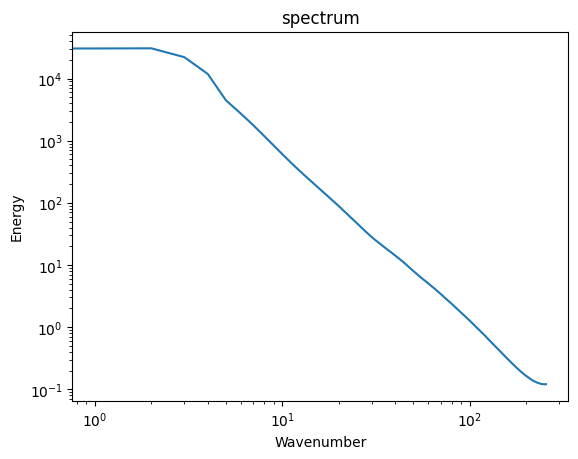

In [5]:
spectrum = get_energy_curve(data[0]['x'][:,:,2,...])
plt.plot(spectrum)
#plt.axvline(x=8, color='orange')
plt.title('spectrum')
plt.ylabel('Energy')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Wavenumber')

Text(0.5, 0, 'Wavenumber')

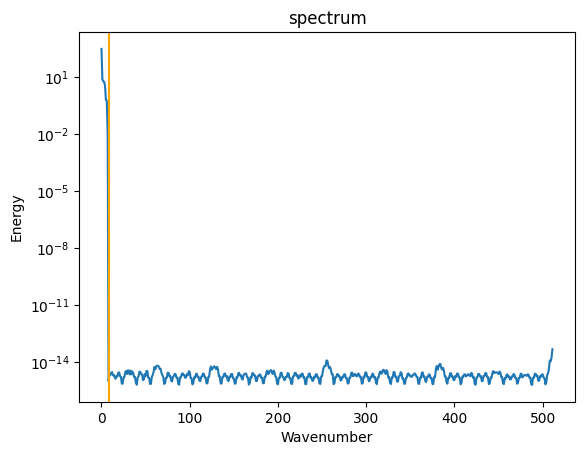

In [38]:
spectrum = get_energy_curve_1d(data[0]['x'])
plt.plot(spectrum)
plt.axvline(x=8, color='orange')
plt.title('spectrum')
plt.ylabel('Energy')
plt.yscale('log')
plt.xlabel('Wavenumber')

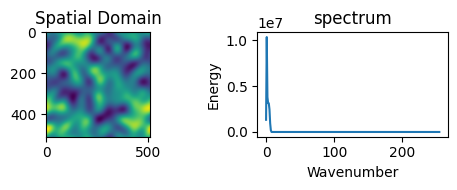

In [12]:
def show_img_and_power_spectrum(image: np.array):
    """Show image and its corresponding energy spectrum."""
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))

    axs[0].imshow(image)
    axs[0].set_title('Spatial Domain')

    spectrum = get_energy_curve(image[None, None, ...])
    axs[1].plot(spectrum)
    axs[1].set_title('spectrum')
    axs[1].set_ylabel('Energy')
    axs[1].set_xlabel('Wavenumber')
    # axs[1].set_xscale("log")

    plt.tight_layout()
    plt.show()

show_img_and_power_spectrum(data[0]['x'][0,0,0,...])

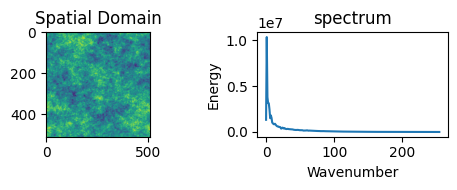

In [14]:
show_img_and_power_spectrum(data[0]['x'][0,0,0,...])

In [1]:
s = '[0, 1, 0, 0]' 

int_list = eval(s)

In [7]:
hp_args = {

                             'resolution_ratios':[0,1,0,0], # high to low
                         }

In [8]:
hp_args['resolution_ratios']

[0, 1, 0, 0]